In [1]:
!unzip /content/drive/MyDrive/ML_Artivatic_dataset.zip

Archive:  /content/drive/MyDrive/ML_Artivatic_dataset.zip
   creating: ML_Artivatic_dataset/
  inflating: ML_Artivatic_dataset/sample_submission.csv  
  inflating: ML_Artivatic_dataset/test_indessa.csv  
  inflating: ML_Artivatic_dataset/train_indessa.csv  


In [2]:
# importing the important library
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [22]:
train_dataset = pd.read_csv('/content/ML_Artivatic_dataset/train_indessa.csv')
test_dataset = pd.read_csv('/content/ML_Artivatic_dataset/test_indessa.csv')

In [4]:
print('Shape of train dataset is ', train_dataset.shape)
print('Shape of test dataset is ', test_dataset.shape)

Shape of train dataset is  (532428, 45)
Shape of test dataset is  (354951, 44)


In [5]:
train_dataset.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


In [6]:
#Lets check the NaN values in the train dataset

train_nan = []
test_nan = []

for col in train_dataset.columns:
    train_nan.append(train_dataset[col].isnull().sum())

for col in test_dataset.columns:
    test_nan.append(test_dataset[col].isnull().sum())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


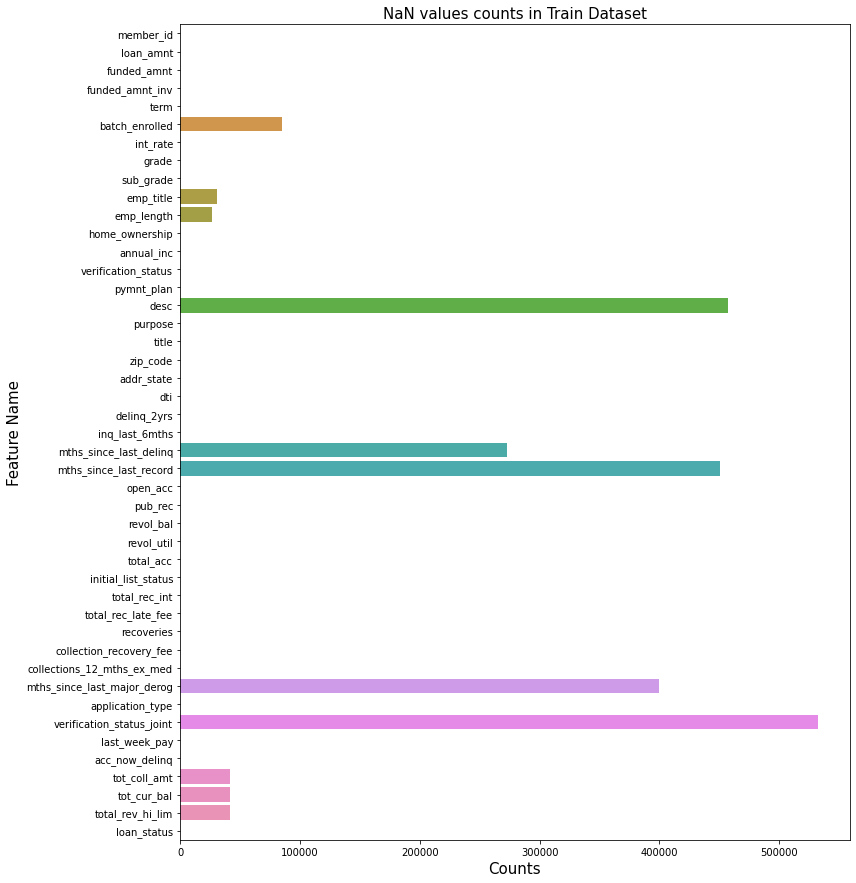

In [7]:
plt.figure(figsize=(12,15))
sns.barplot(train_nan, train_dataset.columns)
plt.xlabel('Counts', fontsize=15)
plt.ylabel('Feature Name', fontsize=15)
plt.title("NaN values counts in Train Dataset", fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


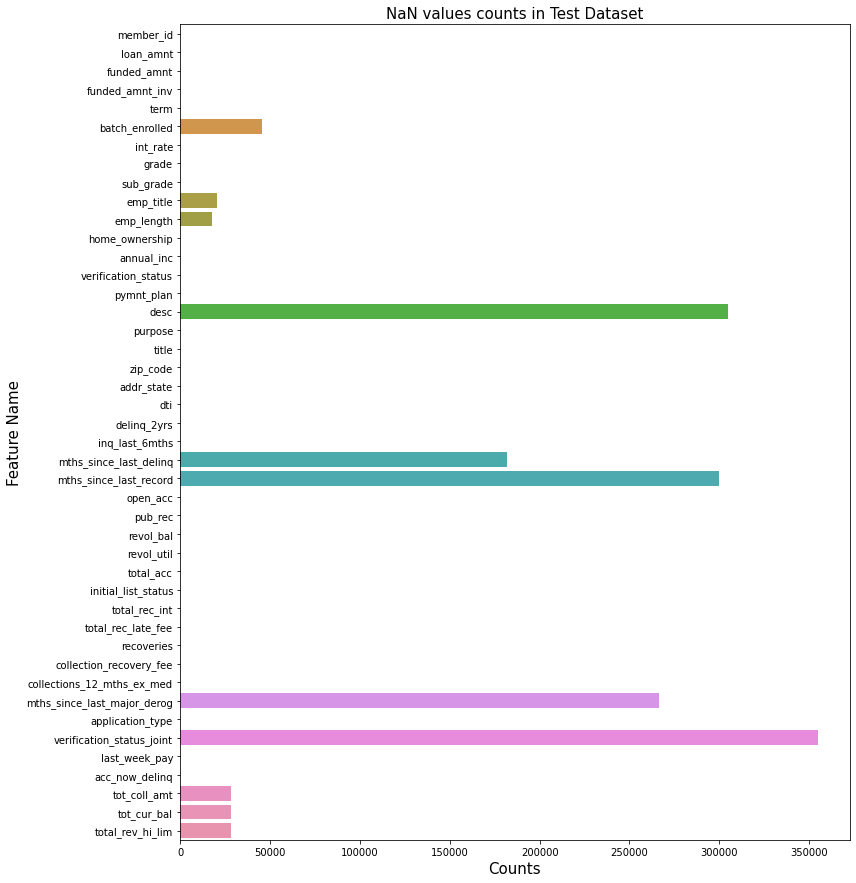

In [8]:
plt.figure(figsize=(12,15))
sns.barplot(test_nan, test_dataset.columns)
plt.xlabel('Counts', fontsize=15)
plt.ylabel('Feature Name', fontsize=15)
plt.title("NaN values counts in Test Dataset", fontsize=15)
plt.show()


**The Distribution of the Missing values are same in Train & Test dataset**

In [6]:
def handle_missing_values(train, test):
    '''This function removes the missing values from the dataset'''

    # this list is a categorical feature lists
    categorical_columns = ['term', 'batch_enrolled', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 
                       'purpose', 'title', 'zip_code', 'addr_state', 'desc', 'initial_list_status', 'application_type', 'last_week_pay']

    for col in train.columns:           
      if col not in categorical_columns:
          if train[col].isnull().sum() > 1000:    # if missing values counts is more than 1000 we will impute 0 for the continues feature
              train[col] = train[col].fillna(0)
              test[col] = test[col].fillna(0)
          else:                                   # impute the median w.r.t to grade feature 
              train[col] = train[col].fillna(train.groupby('grade')[col].transform('median'))
              test[col] = test[col].fillna(test.groupby('grade')[col].transform('median'))
      else:                                       # impute missing values as missing which act as a new category for categorical feature
          train[col] = train[col].fillna('missing') 
          test[col] = test[col].fillna('missing')

    return train, test

In [7]:
y = train_dataset['loan_status']    

# here we are dropping the member id, loan_status & verification_status_joint, verification_status_joint is dropped because 90 % datapoints is missing
train_dataset = train_dataset.drop(['member_id', 'loan_status', 'verification_status_joint'], axis=1)
test_dataset = test_dataset.drop(['member_id', 'verification_status_joint'], axis=1)

In [8]:
train_dataset, test_dataset = handle_missing_values(train_dataset, test_dataset)

In [9]:
def normalize(train, test):
    '''This function standardize each continues feature in same scale'''
    standardizer = MinMaxScaler()
    categorical_columns = ['term', 'batch_enrolled', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 
                       'purpose', 'title', 'zip_code', 'addr_state','desc', 'initial_list_status', 'application_type', 'last_week_pay']
    
    for col in train.columns:
      if col not in categorical_columns:
        train[col] = standardizer.fit_transform(train[col].values.reshape(-1, 1))
        test[col] = standardizer.transform(test[col].values.reshape(-1, 1))
    return train, test

def categorical_encoder(train, test):
    '''This function encode the categorical feature'''
    encoder = LabelEncoder()
    categorical_columns = ['term', 'batch_enrolled', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 
                       'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status', 'desc', 'application_type', 'last_week_pay']
    for col in categorical_columns:
        if col == 'desc':
          train[col] = train[col].apply(lambda x: 0 if x == 'missing' else 1 )
          test[col] = test[col].apply(lambda x: 0 if x == 'missing' else 1 )
        else:
          uniques = train[col].unique().tolist() + test[col].unique().tolist()
          encoder.fit(uniques)
          train[col] = encoder.transform(train[col].astype(str))
          test[col] = encoder.transform(test[col].astype(str))

    return train, test

def preprocessing_data(train, test):
    '''This function preprocess the data for the training'''
    train, test = normalize(train, test)
    train, test = categorical_encoder(train, test)

    return train, test

Train, Test = preprocessing_data(train_dataset, test_dataset)

In [10]:
# splitting the train dataset into Train & CV with size of CV is 20% 
X_train, X_cv, y_train, y_cv = train_test_split(Train, y, test_size=0.2, stratify=y)

In [11]:
# randomized search CV for hyperparameter tunning.
XGB=XGBClassifier(tree_method='gpu_hist')
params={
    'learning_rate':[0.001, 0.01, 0.1, 1],
     'n_estimators':[100, 250, 500, 1000],
     'max_depth':[5,8,10],
    'colsample_bytree' : [0.5, 0.75, 1],
    'subsample': [0.5, 0.75, 1]
}
random_cfl=RandomizedSearchCV(XGB, param_distributions=params, cv=5, scoring='roc_auc', return_train_score=True, verbose=42,n_jobs=-1)
random_cfl.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 54.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 60.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 61

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           seed=None, silent=None, subsample=1,
                                           tree_method='gpu_hist',
                              

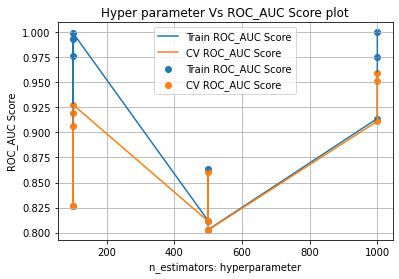

In [14]:
# plotting the Hyperparameter tunning graph 
results = pd.DataFrame.from_dict(random_cfl.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train ROC_AUC Score')

plt.plot(alpha, cv_score, label='CV ROC_AUC Score')

plt.scatter(alpha, train_score, label='Train ROC_AUC Score')
plt.scatter(alpha, cv_score, label='CV ROC_AUC Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("ROC_AUC Score")
plt.title("Hyper parameter Vs ROC_AUC Score plot")
plt.grid()
plt.show()

In [34]:
print(f'Best parameter for XGBoost are {random_cfl.best_params_} with best score is {np.round(random_cfl.best_score_, 4)}')

Best parameter for XGBoost are {'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.75} with best score is 0.9591


In [16]:
# training XGBoost classifier
XGB_clf = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, colsample_bytree=0.75, subsample=1, tree_method='gpu_hist')
XGB_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [18]:
# prediction of the probablities
prediction = XGB_clf.predict_proba(Test)

In [20]:
# the probability that a member will default
prediction = prediction[:,1]

In [23]:
submission = pd.DataFrame(columns=['member_id', 'loan_status'])
submission['member_id'], submission['loan_status'] = test_dataset['member_id'], prediction

In [24]:
submission.to_csv('submission.csv', index=False)

In [25]:
submission.head()

,member_id,loan_status
0,11937648,0.696100
1,38983318,0.201345
2,27999917,0.151427
3,61514932,0.309247
4,59622821,0.116106
